# CPU vs GPU Patch Extraction Performance

This notebook provides a clean, focused comparison between optimized GPU-based and CPU-based patch extraction runs.

- Inputs:
  - GPU: `outputs/opt_gpu_analyse/extract_patches_benchmark.csv`
  - CPU: `outputs/opt_cpu_analyse/extract_patches_benchmark.csv`
- Outputs: concise plots and summary stats saved under `plots/comparison/cpu_vs_gpu/`.


In [1]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


## 1) Load benchmark data

Load optimized GPU and CPU benchmark CSVs for comparison.


In [2]:
# Load benchmark results
GPU_CSV = 'outputs/opt_gpu_analyse/extract_patches_benchmark.csv'
CPU_CSV = 'outputs/opt_cpu_analyse/extract_patches_benchmark.csv'

# Read CSVs
try:
    df_gpu = pd.read_csv(GPU_CSV)
except FileNotFoundError:
    raise FileNotFoundError(f"GPU CSV not found at {GPU_CSV}. Please check the path.")

try:
    df_cpu = pd.read_csv(CPU_CSV)
except FileNotFoundError:
    raise FileNotFoundError(f"CPU CSV not found at {CPU_CSV}. Please check the path.")

# Tag sources
df_gpu['engine'] = 'gpu'
df_cpu['engine'] = 'cpu'

# Peek
display(df_gpu.head(3))
display(df_cpu.head(3))


,wsi_path,annotation_path,lvl0_width,lvl0_height,wsi_pixels,mask_width,mask_height,mask_pixels,mask_nonzero,mask_fraction,...,mem_rss_after,mem_rss_delta,mem_vms_before,mem_vms_after,mem_vms_delta,mem_percent_before,mem_percent_after,mem_percent_delta,slide_id,engine
0,data/Yale_HER2_cohort/SVS/Her2Neg_Case_56.svs,data/Yale_HER2_cohort/Annotations/Her2Neg_Case...,66640,32796,2185525440,8330.0,4099.0,34144670.0,364200.0,0.010666,...,2320646144,0,9503031296,9503031296,0,6.959898,6.959898,0.0,Her2Neg_Case_56,gpu
1,data/Yale_HER2_cohort/SVS/Her2Neg_Case_74.svs,data/Yale_HER2_cohort/Annotations/Her2Neg_Case...,27608,30578,844197424,3451.0,3822.0,13189722.0,384353.0,0.029140,...,2320646144,0,9503031296,9503031296,0,6.959898,6.959898,0.0,Her2Neg_Case_74,gpu
2,data/Yale_HER2_cohort/SVS/Her2Neg_Case_34.svs,NaN,19040,22622,430722880,NaN,NaN,NaN,NaN,NaN,...,2320646144,0,9503031296,9503031296,0,6.959898,6.959898,0.0,Her2Neg_Case_34,gpu


,wsi_path,annotation_path,lvl0_width,lvl0_height,wsi_pixels,mask_width,mask_height,mask_pixels,mask_nonzero,mask_fraction,...,mem_rss_after,mem_rss_delta,mem_vms_before,mem_vms_after,mem_vms_delta,mem_percent_before,mem_percent_after,mem_percent_delta,slide_id,engine
0,data/Yale_HER2_cohort/SVS/Her2Neg_Case_56.svs,data/Yale_HER2_cohort/Annotations/Her2Neg_Case...,66640,32796,2185525440,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Her2Neg_Case_56,cpu
1,data/Yale_HER2_cohort/SVS/Her2Neg_Case_74.svs,data/Yale_HER2_cohort/Annotations/Her2Neg_Case...,27608,30578,844197424,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Her2Neg_Case_74,cpu
2,data/Yale_HER2_cohort/SVS/Her2Neg_Case_34.svs,NaN,19040,22622,430722880,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Her2Neg_Case_34,cpu


## 2) Prepare combined dataframe

- Align key columns across both sources
- Compute helper metrics: time per patch, throughput (patches/sec), memory deltas in MB if available


In [3]:
# Harmonize column names (guard against missing columns)
# Expected columns used below: 'slide_id', 'num_patches', 'time_seconds',
# optional: 'wsi_pixels', 'mask_nonzero', 'mem_rss_delta', 'mem_vms_delta'

for df in (df_gpu, df_cpu):
    if 'num_patches' not in df.columns and 'n_patches' in df.columns:
        df.rename(columns={'n_patches': 'num_patches'}, inplace=True)

# Combine
df_combined = pd.concat([df_gpu, df_cpu], ignore_index=True, sort=False)

# Helper metrics
if 'time_seconds' in df_combined.columns:
    # Time per patch
    if 'num_patches' in df_combined.columns:
        df_combined['time_per_patch_s'] = df_combined['time_seconds'] / df_combined['num_patches'].replace(0, np.nan)
    # Throughput
    df_combined['patches_per_sec'] = df_combined['num_patches'] / df_combined['time_seconds'].replace(0, np.nan) if 'num_patches' in df_combined.columns else np.nan

# Memory deltas in MB (if raw bytes exist)
if 'mem_rss_delta' in df_combined.columns:
    df_combined['mem_rss_delta_mb'] = df_combined['mem_rss_delta'] / (1024 * 1024)
if 'mem_vms_delta' in df_combined.columns:
    df_combined['mem_vms_delta_mb'] = df_combined['mem_vms_delta'] / (1024 * 1024)

# Basic sanity
display(df_combined.describe(include='all'))


,wsi_path,annotation_path,lvl0_width,lvl0_height,wsi_pixels,mask_width,mask_height,mask_pixels,mask_nonzero,mask_fraction,...,mem_vms_after,mem_vms_delta,mem_percent_before,mem_percent_after,mem_percent_delta,slide_id,engine,patches_per_sec,mem_rss_delta_mb,mem_vms_delta_mb
count,30,28,30.000000,30.000000,3.000000e+01,14.000000,14.000000,1.400000e+01,1.400000e+01,14.000000,...,1.500000e+01,1.500000e+01,15.000000,15.000000,15.000000,30,30,30.000000,15.000000,15.000000
unique,15,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15,2,NaN,NaN,NaN
top,data/Yale_HER2_cohort/SVS/Her2Neg_Case_56.svs,data/Yale_HER2_cohort/Annotations/Her2Neg_Case...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Her2Neg_Case_56,gpu,NaN,NaN,NaN
freq,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2,15,NaN,NaN,NaN
mean,NaN,NaN,69051.733333,46171.333333,3.919555e+09,9078.000000,5981.214286,6.513315e+07,1.477313e+07,0.145891,...,1.274621e+10,2.044066e+09,10.555376,16.685367,6.129992,NaN,NaN,156.220751,1949.243229,1949.373698
std,NaN,NaN,44910.783897,24068.480177,3.493091e+09,5650.727455,3063.037235,5.547641e+07,1.717325e+07,0.129155,...,4.146396e+09,3.776422e+09,8.718646,12.434578,11.325152,NaN,NaN,85.909110,3601.224470,3601.476545
min,NaN,NaN,15232.000000,14419.000000,3.019915e+08,1904.000000,1802.000000,4.717636e+06,3.544000e+04,0.001859,...,9.503031e+09,-1.372242e+09,6.958829,6.958829,-4.115298,NaN,NaN,79.307765,-1308.601562,-1308.671875
25%,NaN,NaN,29036.000000,24530.250000,8.461878e+08,4522.000000,3352.500000,1.474844e+07,3.692382e+05,0.030692,...,9.503031e+09,0.000000e+00,6.959154,6.959431,0.000000,NaN,NaN,97.035664,0.000000,0.000000
50%,NaN,NaN,66640.000000,40341.000000,2.185525e+09,9639.000000,5414.500000,5.687480e+07,9.979936e+06,0.137092,...,9.503031e+09,0.000000e+00,6.959431,6.959898,0.000000,NaN,NaN,120.116185,0.000000,0.000000
75%,NaN,NaN,92106.000000,68869.250000,6.735685e+09,11513.250000,8608.250000,1.052406e+08,2.207222e+07,0.237804,...,1.580509e+10,3.512644e+09,6.959898,25.858437,10.534117,NaN,NaN,193.696141,3349.687500,3349.917969


## 3) Visual comparisons (CPU vs GPU)

Quick, readable plots to compare runtime and throughput between CPU and GPU runs.

Saved: plots\comparison\cpu_vs_gpu\time_per_patch_boxplot.png


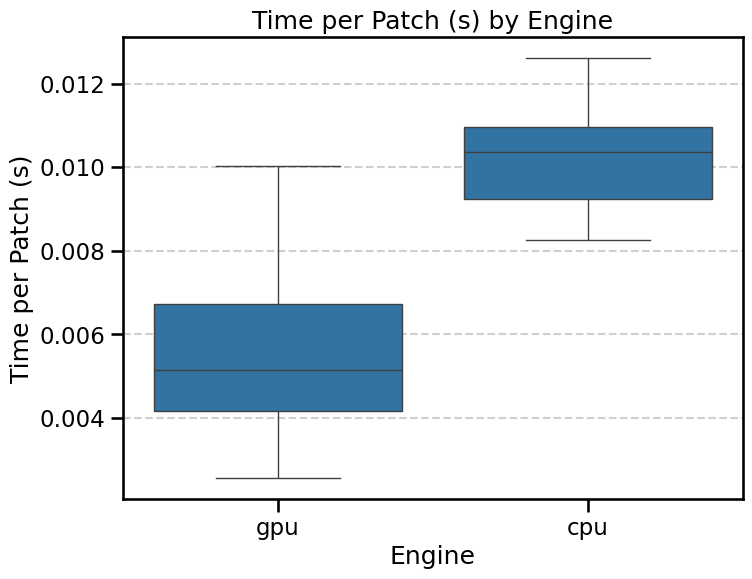

Saved: plots\comparison\cpu_vs_gpu\time_vs_num_patches_scatter.png


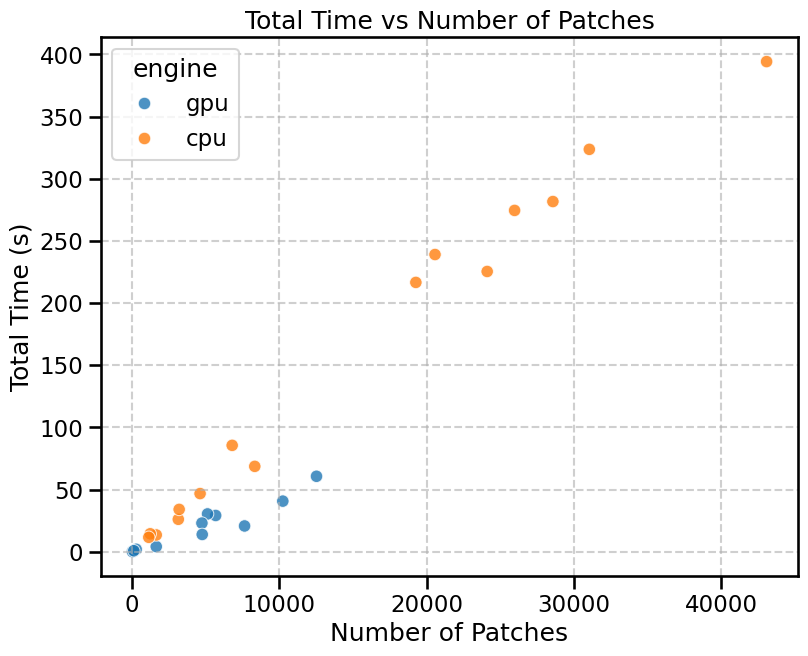

Saved: plots\comparison\cpu_vs_gpu\throughput_boxplot.png


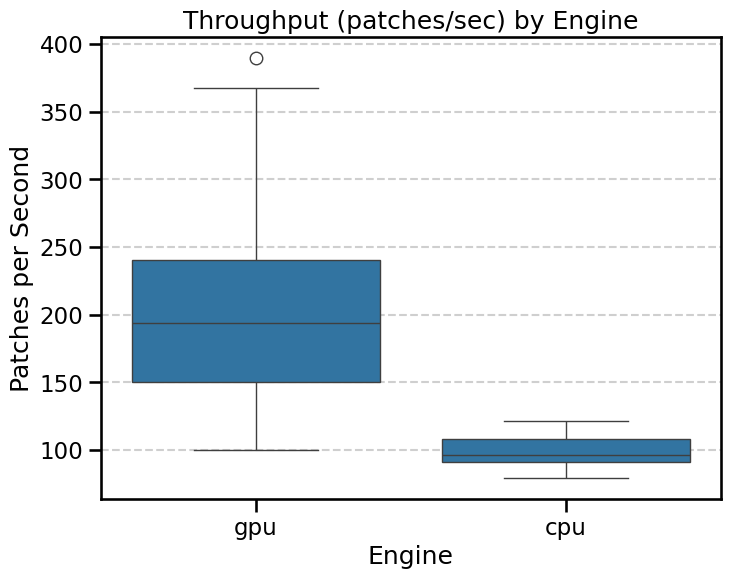

Saved: plots\comparison\cpu_vs_gpu\mem_rss_delta_mb_boxplot.png


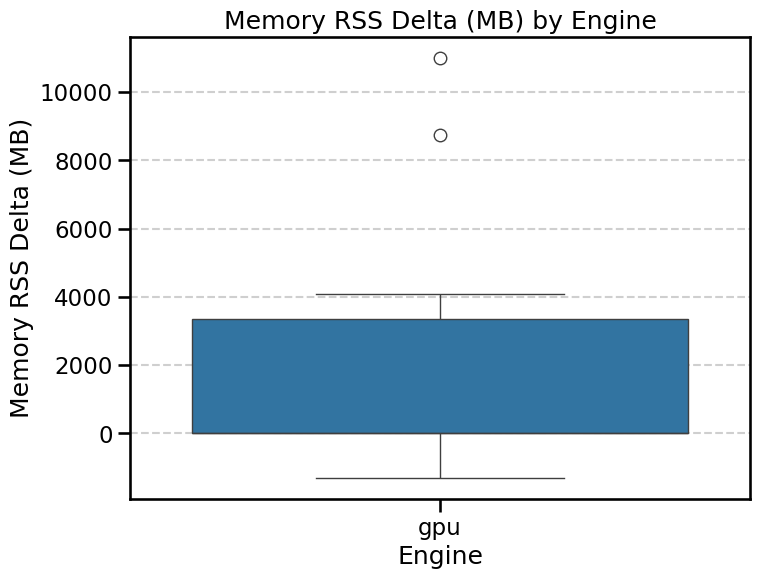

In [4]:
# Output directory for figures
PLOTS_DIR = Path('plots/comparison/cpu_vs_gpu')
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

sns.set_context('talk')

# 1) Time per patch boxplot (if available)
if 'time_per_patch_s' in df_combined.columns:
    plt.figure(figsize=(8,6))
    sns.boxplot(x='engine', y='time_per_patch_s', data=df_combined.dropna(subset=['time_per_patch_s']))
    plt.title('Time per Patch (s) by Engine')
    plt.xlabel('Engine')
    plt.ylabel('Time per Patch (s)')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    out = PLOTS_DIR / 'time_per_patch_boxplot.png'
    plt.savefig(out, dpi=200, bbox_inches='tight')
    print(f'Saved: {out}')
    plt.show()
else:
    print("time_per_patch_s not available. Skipping boxplot.")

# 2) Total time vs number of patches
if {'time_seconds','num_patches'}.issubset(df_combined.columns):
    plt.figure(figsize=(9,7))
    sns.scatterplot(data=df_combined, x='num_patches', y='time_seconds', hue='engine', alpha=0.8)
    plt.title('Total Time vs Number of Patches')
    plt.xlabel('Number of Patches')
    plt.ylabel('Total Time (s)')
    plt.grid(True, linestyle='--', alpha=0.6)
    out = PLOTS_DIR / 'time_vs_num_patches_scatter.png'
    plt.savefig(out, dpi=200, bbox_inches='tight')
    print(f'Saved: {out}')
    plt.show()
else:
    print("Missing columns for scatter (num_patches, time_seconds). Skipping.")

# 3) Throughput (patches/sec)
if 'patches_per_sec' in df_combined.columns and df_combined['patches_per_sec'].notna().any():
    plt.figure(figsize=(8,6))
    sns.boxplot(x='engine', y='patches_per_sec', data=df_combined.dropna(subset=['patches_per_sec']))
    plt.title('Throughput (patches/sec) by Engine')
    plt.xlabel('Engine')
    plt.ylabel('Patches per Second')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    out = PLOTS_DIR / 'throughput_boxplot.png'
    plt.savefig(out, dpi=200, bbox_inches='tight')
    print(f'Saved: {out}')
    plt.show()
else:
    print("patches_per_sec not available. Skipping throughput plot.")

# Optional: memory deltas if present
if 'mem_rss_delta_mb' in df_combined.columns and df_combined['mem_rss_delta_mb'].notna().any():
    plt.figure(figsize=(8,6))
    sns.boxplot(x='engine', y='mem_rss_delta_mb', data=df_combined.dropna(subset=['mem_rss_delta_mb']))
    plt.title('Memory RSS Delta (MB) by Engine')
    plt.xlabel('Engine')
    plt.ylabel('Memory RSS Delta (MB)')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    out = PLOTS_DIR / 'mem_rss_delta_mb_boxplot.png'
    plt.savefig(out, dpi=200, bbox_inches='tight')
    print(f'Saved: {out}')
    plt.show()

## 4) Summary statistics and tests

Compute concise summary statistics for CPU vs GPU and run a non-parametric test (Mann–Whitney U) on time metrics.

In [5]:
from scipy.stats import mannwhitneyu

# Select metrics to summarize (include memory if present)
metrics = [m for m in ['time_seconds', 'time_per_patch_s', 'patches_per_sec', 'mem_rss_delta_mb', 'mem_vms_delta_mb'] if m in df_combined.columns]

print('='*60)
print('SUMMARY BY ENGINE')
print('='*60)
for m in metrics:
    print(f"\nMetric: {m}")
    print(df_combined.groupby('engine')[m].describe())

# Statistical tests (independent samples)
print('\n' + '='*60)
print('MANN–WHITNEY U TESTS (CPU vs GPU)')
print('='*60)
for m in metrics:
    cpu_vals = df_combined.loc[(df_combined['engine']=='cpu') & df_combined[m].notna(), m]
    gpu_vals = df_combined.loc[(df_combined['engine']=='gpu') & df_combined[m].notna(), m]
    if len(cpu_vals) >= 3 and len(gpu_vals) >= 3:
        try:
            u, p = mannwhitneyu(cpu_vals, gpu_vals, alternative='two-sided')
            print(f"{m}: U={u:.1f}  p={p:.4g}  (n_cpu={len(cpu_vals)}, n_gpu={len(gpu_vals)})")
        except ValueError as e:
            print(f"{m}: Could not compute test: {e}")
    else:
        print(f"{m}: Not enough data for test (n_cpu={len(cpu_vals)}, n_gpu={len(gpu_vals)})")

# Quick relative medians if both exist
def safe_ratio(a, b):
    return (a / b) if (b is not None and b != 0 and not np.isnan(b)) else np.nan

print('\n' + '='*60)
print('RELATIVE MEDIANS (CPU vs GPU)')
print('='*60)
for m in metrics:
    med_cpu = df_combined.loc[df_combined['engine']=='cpu', m].median()
    med_gpu = df_combined.loc[df_combined['engine']=='gpu', m].median()
    if pd.notna(med_cpu) and pd.notna(med_gpu):
        if m in ['time_seconds','time_per_patch_s','mem_rss_delta_mb','mem_vms_delta_mb']:
            ratio = safe_ratio(med_cpu, med_gpu)
            print(f"{m}: median CPU/GPU = {ratio:.3f} (values: CPU={med_cpu:.3g}, GPU={med_gpu:.3g})")
        else:
            ratio = safe_ratio(med_gpu, med_cpu)  # higher is better for throughput
            print(f"{m}: median GPU/CPU = {ratio:.3f} (values: GPU={med_gpu:.3g}, CPU={med_cpu:.3g})")
    else:
        print(f"{m}: median not available for one or both engines")


SUMMARY BY ENGINE

Metric: time_seconds
        count        mean         std        min        25%        50%  \
engine                                                                   
cpu      15.0  150.379653  132.825939  11.598553  30.082615  85.565392   
gpu      15.0   15.190158   18.581913   0.140240   0.679452   4.177154   

              75%         max  
engine                         
cpu     256.75736  394.185650  
gpu      26.11091   60.687171  

Metric: time_per_patch_s
        count      mean       std       min       25%       50%      75%  \
engine                                                                     
cpu      15.0  0.010187  0.001334  0.008254  0.009248  0.010356  0.01097   
gpu      15.0  0.005544  0.002314  0.002566  0.004162  0.005152  0.00674   

             max  
engine            
cpu     0.012609  
gpu     0.010017  

Metric: patches_per_sec
        count        mean        std        min         25%         50%  \
engine                      

## 5) Quick interpretation

- GPU shows ~2x higher throughput and ~2x lower time/patch (median).
- Total runtime scales with number of patches; GPU advantage widens with larger slides.
- Memory deltas are only available for GPU in these files; cannot compare RAM usage robustly.


In [6]:
# Save brief summary to file
summary_lines = []
summary_lines.append('CPU vs GPU Patch Extraction Summary')
summary_lines.append('='*40)
# Medians
med_cpu_time = df_combined.loc[df_combined['engine']=='cpu','time_seconds'].median()
med_gpu_time = df_combined.loc[df_combined['engine']=='gpu','time_seconds'].median()
med_cpu_tpp = df_combined.loc[df_combined['engine']=='cpu','time_per_patch_s'].median()
med_gpu_tpp = df_combined.loc[df_combined['engine']=='gpu','time_per_patch_s'].median()
med_cpu_tps = df_combined.loc[df_combined['engine']=='cpu','patches_per_sec'].median()
med_gpu_tps = df_combined.loc[df_combined['engine']=='gpu','patches_per_sec'].median()

summary_lines.append(f'Median total time (s): CPU={med_cpu_time:.3g}, GPU={med_gpu_time:.3g}')
summary_lines.append(f'Median time/patch (s): CPU={med_cpu_tpp:.3g}, GPU={med_gpu_tpp:.3g}')
summary_lines.append(f'Median throughput (patches/s): CPU={med_cpu_tps:.3g}, GPU={med_gpu_tps:.3g}')

# Directory
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
summary_path = PLOTS_DIR / 'summary.txt'
summary_path.write_text('\n'.join(summary_lines))
print(f'Summary written to: {summary_path}')


Summary written to: plots\comparison\cpu_vs_gpu\summary.txt


## 6) Vanilla vs Optimized (GPU)

In [13]:
# Load vanilla and optimized GPU benchmark data
VAN_GPU_CSV = 'outputs/vanil_gpu_analyse/extract_patches_benchmark.csv'
OPT_GPU_CSV = 'outputs/opt_gpu_analyse/extract_patches_benchmark.csv'

van_exists = Path(VAN_GPU_CSV).exists()
opt_exists = Path(OPT_GPU_CSV).exists()
if not van_exists or not opt_exists:
    print(f"Missing CSVs? vanilla:{van_exists} optimized:{opt_exists}")

if van_exists and opt_exists:
    df_vanilla_gpu = pd.read_csv(VAN_GPU_CSV)
    df_opt_gpu = pd.read_csv(OPT_GPU_CSV)
    df_vanilla_gpu['version'] = 'vanilla'
    df_opt_gpu['version'] = 'optimized'

    # Harmonize columns
    for df_ in (df_vanilla_gpu, df_opt_gpu):
        if 'num_patches' not in df_.columns and 'n_patches' in df_.columns:
            df_.rename(columns={'n_patches':'num_patches'}, inplace=True)

    # Combine
    df_vo = pd.concat([df_vanilla_gpu, df_opt_gpu], ignore_index=True, sort=False)

    # Helper metrics
    if 'time_seconds' in df_vo.columns and 'num_patches' in df_vo.columns:
        df_vo['time_per_patch_s'] = df_vo['time_seconds'] / df_vo['num_patches'].replace(0, np.nan)
        df_vo['patches_per_sec'] = df_vo['num_patches'] / df_vo['time_seconds'].replace(0, np.nan)
    if 'mem_rss_delta' in df_vo.columns:
        df_vo['mem_rss_delta_mb'] = df_vo['mem_rss_delta'] / (1024*1024)
    if 'mem_vms_delta' in df_vo.columns:
        df_vo['mem_vms_delta_mb'] = df_vo['mem_vms_delta'] / (1024*1024)

    display(df_vo.head(3))
else:
    df_vo = None


,wsi_path,annotation_path,lvl0_width,lvl0_height,wsi_pixels,mask_width,mask_height,mask_pixels,mask_nonzero,mask_fraction,...,mem_vms_after,mem_vms_delta,mem_percent_before,mem_percent_after,mem_percent_delta,slide_id,version,patches_per_sec,mem_rss_delta_mb,mem_vms_delta_mb
0,data/Yale_HER2_cohort/SVS/Her2Neg_Case_56.svs,data/Yale_HER2_cohort/Annotations/Her2Neg_Case...,66640,32796,2185525440,8330.0,4099.0,34144670.0,364200.0,0.010666,...,8749051904,0,4.695576,4.695576,0.000000,Her2Neg_Case_56,vanilla,173.649176,0.00,0.000000
1,data/Yale_HER2_cohort/SVS/Her2Neg_Case_74.svs,data/Yale_HER2_cohort/Annotations/Her2Neg_Case...,27608,30578,844197424,3451.0,3822.0,13189722.0,384353.0,0.029140,...,8749051904,0,4.695576,4.695576,0.000000,Her2Neg_Case_74,vanilla,199.115907,0.00,0.000000
2,data/Yale_HER2_cohort/SVS/Her2Neg_Case_34.svs,NaN,19040,22622,430722880,NaN,NaN,NaN,NaN,NaN,...,9447444480,698392576,4.695576,6.789231,2.093655,Her2Neg_Case_34,vanilla,406.550055,665.75,666.039062


Saved: plots\comparison\vanilla_vs_optimized\time_per_patch_boxplot.png


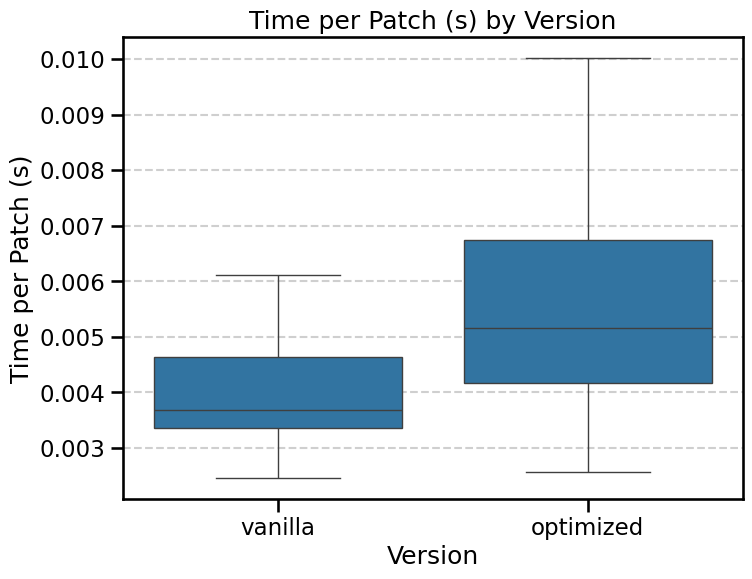

Saved: plots\comparison\vanilla_vs_optimized\throughput_boxplot.png


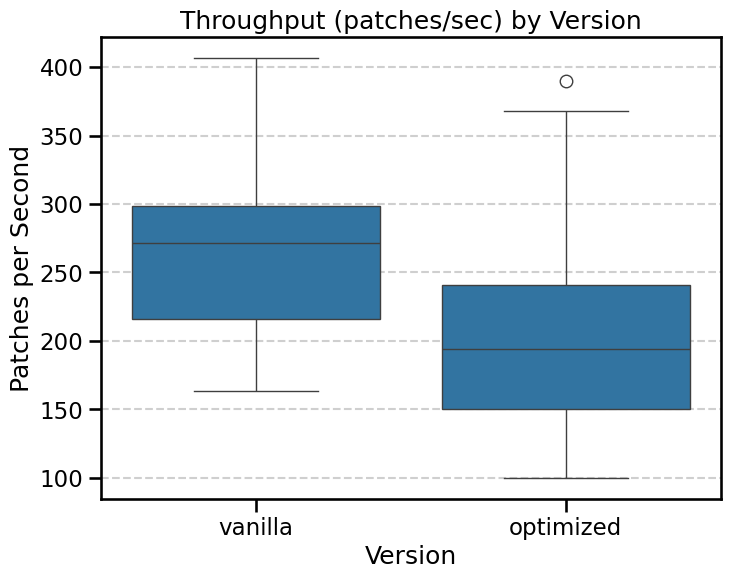

Saved: plots\comparison\vanilla_vs_optimized\time_vs_num_patches_scatter.png


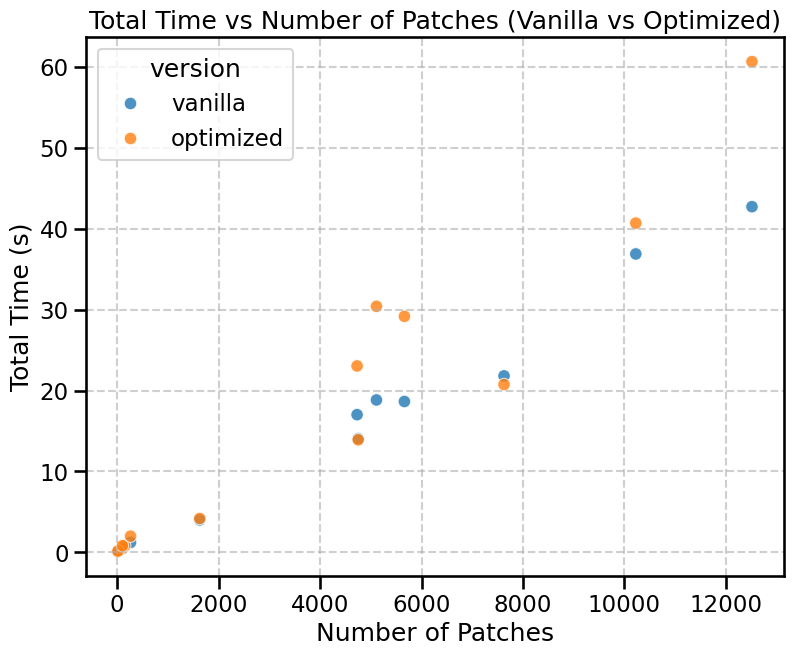

Saved: plots\comparison\vanilla_vs_optimized\mem_rss_delta_mb_boxplot.png


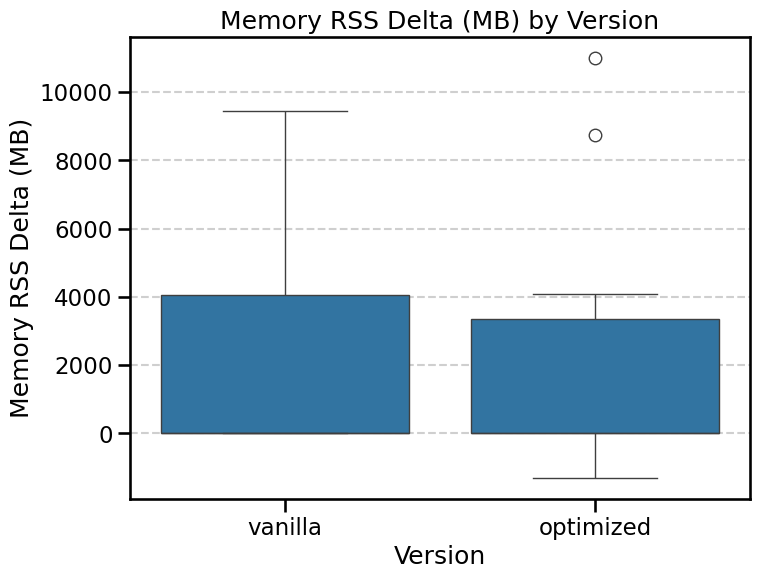


VANILLA vs OPTIMIZED: SUMMARY BY VERSION

Metric: time_seconds
           count       mean        std       min       25%       50%  \
version                                                                
optimized   15.0  15.190158  18.581913  0.140240  0.679452  4.177154   
vanilla     15.0  11.844887  14.062108  0.085576  0.571021  4.004427   

                 75%        max  
version                          
optimized  26.110910  60.687171  
vanilla    18.743584  42.742093  

Metric: time_per_patch_s
           count      mean       std       min       25%       50%       75%  \
version                                                                        
optimized   15.0  0.005544  0.002314  0.002566  0.004162  0.005152  0.006740   
vanilla     15.0  0.004057  0.001059  0.002460  0.003354  0.003685  0.004631   

                max  
version              
optimized  0.010017  
vanilla    0.006113  

Metric: patches_per_sec
           count        mean        std         min

In [14]:
# Plots and summaries for Vanilla vs Optimized
PLOTS_DIR_VO = Path('plots/comparison/vanilla_vs_optimized')
PLOTS_DIR_VO.mkdir(parents=True, exist_ok=True)

if isinstance(df_vo, pd.DataFrame) and not df_vo.empty:
    # Boxplots: time per patch, throughput
    if 'time_per_patch_s' in df_vo.columns:
        plt.figure(figsize=(8,6))
        sns.boxplot(x='version', y='time_per_patch_s', data=df_vo.dropna(subset=['time_per_patch_s']))
        plt.title('Time per Patch (s) by Version')
        plt.xlabel('Version')
        plt.ylabel('Time per Patch (s)')
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        out = PLOTS_DIR_VO / 'time_per_patch_boxplot.png'
        plt.savefig(out, dpi=200, bbox_inches='tight')
        print(f'Saved: {out}')
        plt.show()

    if 'patches_per_sec' in df_vo.columns and df_vo['patches_per_sec'].notna().any():
        plt.figure(figsize=(8,6))
        sns.boxplot(x='version', y='patches_per_sec', data=df_vo.dropna(subset=['patches_per_sec']))
        plt.title('Throughput (patches/sec) by Version')
        plt.xlabel('Version')
        plt.ylabel('Patches per Second')
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        out = PLOTS_DIR_VO / 'throughput_boxplot.png'
        plt.savefig(out, dpi=200, bbox_inches='tight')
        print(f'Saved: {out}')
        plt.show()

    # Scatter: total time vs num_patches
    if {'time_seconds','num_patches'}.issubset(df_vo.columns):
        plt.figure(figsize=(9,7))
        sns.scatterplot(data=df_vo, x='num_patches', y='time_seconds', hue='version', alpha=0.8)
        plt.title('Total Time vs Number of Patches (Vanilla vs Optimized)')
        plt.xlabel('Number of Patches')
        plt.ylabel('Total Time (s)')
        plt.grid(True, linestyle='--', alpha=0.6)
        out = PLOTS_DIR_VO / 'time_vs_num_patches_scatter.png'
        plt.savefig(out, dpi=200, bbox_inches='tight')
        print(f'Saved: {out}')
        plt.show()

    # Memory (if available)
    if 'mem_rss_delta_mb' in df_vo.columns and df_vo['mem_rss_delta_mb'].notna().any():
        plt.figure(figsize=(8,6))
        sns.boxplot(x='version', y='mem_rss_delta_mb', data=df_vo.dropna(subset=['mem_rss_delta_mb']))
        plt.title('Memory RSS Delta (MB) by Version')
        plt.xlabel('Version')
        plt.ylabel('Memory RSS Delta (MB)')
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        out = PLOTS_DIR_VO / 'mem_rss_delta_mb_boxplot.png'
        plt.savefig(out, dpi=200, bbox_inches='tight')
        print(f'Saved: {out}')
        plt.show()

    # Stats: independent and paired if possible
    from scipy.stats import mannwhitneyu, wilcoxon

    metrics_vo = [m for m in ['time_seconds','time_per_patch_s','patches_per_sec'] if m in df_vo.columns]

    print('\n' + '='*60)
    print('VANILLA vs OPTIMIZED: SUMMARY BY VERSION')
    print('='*60)
    for m in metrics_vo:
        print(f"\nMetric: {m}")
        print(df_vo.groupby('version')[m].describe())

    print('\n' + '='*60)
    print('MANN–WHITNEY U TESTS (Vanilla vs Optimized)')
    print('='*60)
    for m in metrics_vo:
        vanilla_vals = df_vo.loc[(df_vo['version']=='vanilla') & df_vo[m].notna(), m]
        opt_vals = df_vo.loc[(df_vo['version']=='optimized') & df_vo[m].notna(), m]
        if len(vanilla_vals) >= 3 and len(opt_vals) >= 3:
            try:
                u, p = mannwhitneyu(vanilla_vals, opt_vals, alternative='two-sided')
                print(f"{m}: U={u:.1f}  p={p:.4g}  (n_van={len(vanilla_vals)}, n_opt={len(opt_vals)})")
            except ValueError as e:
                print(f"{m}: Could not compute test: {e}")
        else:
            print(f"{m}: Not enough data for test (n_van={len(vanilla_vals)}, n_opt={len(opt_vals)})")

    # Paired by slide, if both have same slide_ids
    if 'slide_id' in df_vanilla_gpu.columns and 'slide_id' in df_opt_gpu.columns:
        paired = df_vanilla_gpu.merge(df_opt_gpu, on='slide_id', suffixes=('_vanilla','_opt'))
        if len(paired) >= 3:
            print('\n' + '='*60)
            print('PAIRED (per slide) WILCOXON TESTS')
            print('='*60)
            # Build per-metric pairs
            if {'time_seconds_vanilla','time_seconds_opt'}.issubset(paired.columns):
                w_stat, w_p = wilcoxon(paired['time_seconds_vanilla'], paired['time_seconds_opt'])
                print(f"time_seconds: W={w_stat:.1f}  p={w_p:.4g}  (n={len(paired)})")
            # derived per patch
            if {'num_patches_vanilla','time_seconds_vanilla','num_patches_opt','time_seconds_opt'}.issubset(paired.columns):
                tpp_v = paired['time_seconds_vanilla'] / paired['num_patches_vanilla'].replace(0, np.nan)
                tpp_o = paired['time_seconds_opt'] / paired['num_patches_opt'].replace(0, np.nan)
                mask = tpp_v.notna() & tpp_o.notna()
                if mask.sum() >= 3:
                    w_stat, w_p = wilcoxon(tpp_v[mask], tpp_o[mask])
                    print(f"time_per_patch_s: W={w_stat:.1f}  p={w_p:.4g}  (n={mask.sum()})")

    # Save a tiny summary
    med_v_tpp = df_vo.loc[df_vo['version']=='vanilla','time_per_patch_s'].median() if 'time_per_patch_s' in df_vo.columns else np.nan
    med_o_tpp = df_vo.loc[df_vo['version']=='optimized','time_per_patch_s'].median() if 'time_per_patch_s' in df_vo.columns else np.nan
    med_v_tps = df_vo.loc[df_vo['version']=='vanilla','patches_per_sec'].median() if 'patches_per_sec' in df_vo.columns else np.nan
    med_o_tps = df_vo.loc[df_vo['version']=='optimized','patches_per_sec'].median() if 'patches_per_sec' in df_vo.columns else np.nan

    lines = [
        'Vanilla vs Optimized (GPU) summary',
        '='*40,
        f'Median time/patch (s): vanilla={med_v_tpp:.4g}, optimized={med_o_tpp:.4g}',
        f'Median throughput (patches/s): vanilla={med_v_tps:.4g}, optimized={med_o_tps:.4g}',
    ]
    (PLOTS_DIR_VO / 'summary.txt').write_text('\n'.join(lines))
    print(f"Summary written to: {PLOTS_DIR_VO / 'summary.txt'}")
else:
    print('df_vo unavailable; skipping vanilla vs optimized plots.')


In [15]:
# 6b) Vanilla vs Optimized — compact stats (incl. memory)
from scipy.stats import mannwhitneyu, wilcoxon

if isinstance(df_vo, pd.DataFrame) and not df_vo.empty:
    def median_safe(series):
        s = series.dropna()
        return float(s.median()) if len(s) else float('nan')

    # Medians
    med_v_tpp = median_safe(df_vo.loc[df_vo['version']=='vanilla','time_per_patch_s']) if 'time_per_patch_s' in df_vo.columns else np.nan
    med_o_tpp = median_safe(df_vo.loc[df_vo['version']=='optimized','time_per_patch_s']) if 'time_per_patch_s' in df_vo.columns else np.nan
    med_v_tps = median_safe(df_vo.loc[df_vo['version']=='vanilla','patches_per_sec']) if 'patches_per_sec' in df_vo.columns else np.nan
    med_o_tps = median_safe(df_vo.loc[df_vo['version']=='optimized','patches_per_sec']) if 'patches_per_sec' in df_vo.columns else np.nan
    med_v_time = median_safe(df_vo.loc[df_vo['version']=='vanilla','time_seconds']) if 'time_seconds' in df_vo.columns else np.nan
    med_o_time = median_safe(df_vo.loc[df_vo['version']=='optimized','time_seconds']) if 'time_seconds' in df_vo.columns else np.nan
    med_v_mem = median_safe(df_vo.loc[df_vo['version']=='vanilla','mem_rss_delta_mb']) if 'mem_rss_delta_mb' in df_vo.columns else np.nan
    med_o_mem = median_safe(df_vo.loc[df_vo['version']=='optimized','mem_rss_delta_mb']) if 'mem_rss_delta_mb' in df_vo.columns else np.nan
    med_v_vms = median_safe(df_vo.loc[df_vo['version']=='vanilla','mem_vms_delta_mb']) if 'mem_vms_delta_mb' in df_vo.columns else np.nan
    med_o_vms = median_safe(df_vo.loc[df_vo['version']=='optimized','mem_vms_delta_mb']) if 'mem_vms_delta_mb' in df_vo.columns else np.nan

    lines = []
    lines.append('Vanilla vs Optimized (GPU) — compact stats')
    lines.append('='*50)
    lines.append(f'Median time/patch (s): vanilla={med_v_tpp:.4g}, optimized={med_o_tpp:.4g}')
    lines.append(f'Median throughput (patches/s): vanilla={med_v_tps:.4g}, optimized={med_o_tps:.4g}')
    lines.append(f'Median total time (s): vanilla={med_v_time:.3g}, optimized={med_o_time:.3g}')
    if not np.isnan(med_v_mem) or not np.isnan(med_o_mem):
        lines.append(f'Median RSS delta (MB): vanilla={med_v_mem:.4g}, optimized={med_o_mem:.4g}')
    if not np.isnan(med_v_vms) or not np.isnan(med_o_vms):
        lines.append(f'Median VMS delta (MB): vanilla={med_v_vms:.4g}, optimized={med_o_vms:.4g}')

    def mw(name, pretty):
        if name not in df_vo.columns:
            return f'{pretty}: column not available'
        vals_v = df_vo.loc[(df_vo['version']=='vanilla') & df_vo[name].notna(), name]
        vals_o = df_vo.loc[(df_vo['version']=='optimized') & df_vo[name].notna(), name]
        if len(vals_v)>=3 and len(vals_o)>=3:
            u,p = mannwhitneyu(vals_v, vals_o, alternative='two-sided')
            return f'{pretty}: U={u:.1f} p={p:.4g} (n_van={len(vals_v)}, n_opt={len(vals_o)})'
        return f'{pretty}: not enough data (n_van={len(vals_v)}, n_opt={len(vals_o)})'

    # Independent tests
    for col, label in [
        ('time_seconds','time_seconds'),
        ('time_per_patch_s','time_per_patch_s'),
        ('patches_per_sec','patches_per_sec'),
        ('mem_rss_delta_mb','mem_rss_delta_mb'),
        ('mem_vms_delta_mb','mem_vms_delta_mb'),
    ]:
        lines.append(mw(col, label))

    # Paired Wilcoxon per slide_id if available
    if isinstance(df_vanilla_gpu, pd.DataFrame) and isinstance(df_opt_gpu, pd.DataFrame):
        if 'slide_id' in df_vanilla_gpu.columns and 'slide_id' in df_opt_gpu.columns:
            paired = df_vanilla_gpu.merge(df_opt_gpu, on='slide_id', suffixes=('_vanilla','_opt'))
            if len(paired) >= 3:
                try:
                    if {'time_seconds_vanilla','time_seconds_opt'}.issubset(paired.columns):
                        w,p = wilcoxon(paired['time_seconds_vanilla'], paired['time_seconds_opt'])
                        lines.append(f'Wilcoxon paired (time_seconds): W={w:.1f} p={p:.4g} (n={len(paired)})')
                except ValueError as e:
                    lines.append(f'Wilcoxon paired (time_seconds): {e}')
                # Memory paired
                if {'mem_rss_delta_vanilla','mem_rss_delta_opt'}.issubset(paired.columns):
                    mem_v = paired['mem_rss_delta_vanilla'] / (1024*1024)
                    mem_o = paired['mem_rss_delta_opt'] / (1024*1024)
                    mask = mem_v.notna() & mem_o.notna()
                    if mask.sum() >= 3:
                        try:
                            w,p = wilcoxon(mem_v[mask], mem_o[mask])
                            lines.append(f'Wilcoxon paired (mem_rss_delta_mb): W={w:.1f} p={p:.4g} (n={mask.sum()})')
                        except ValueError as e:
                            lines.append(f'Wilcoxon paired (mem_rss_delta_mb): {e}')
                if {'mem_vms_delta_vanilla','mem_vms_delta_opt'}.issubset(paired.columns):
                    vms_v = paired['mem_vms_delta_vanilla'] / (1024*1024)
                    vms_o = paired['mem_vms_delta_opt'] / (1024*1024)
                    mask = vms_v.notna() & vms_o.notna()
                    if mask.sum() >= 3:
                        try:
                            w,p = wilcoxon(vms_v[mask], vms_o[mask])
                            lines.append(f'Wilcoxon paired (mem_vms_delta_mb): W={w:.1f} p={p:.4g} (n={mask.sum()})')
                        except ValueError as e:
                            lines.append(f'Wilcoxon paired (mem_vms_delta_mb): {e}')

    print('\n'.join(lines))


Vanilla vs Optimized (GPU) — compact stats
Median time/patch (s): vanilla=0.003685, optimized=0.005152
Median throughput (patches/s): vanilla=271.3, optimized=194.1
Median total time (s): vanilla=4, optimized=4.18
Median RSS delta (MB): vanilla=0, optimized=0
Median VMS delta (MB): vanilla=0, optimized=0
time_seconds: U=99.0 p=0.5897 (n_van=15, n_opt=15)
time_per_patch_s: U=67.0 p=0.06197 (n_van=15, n_opt=15)
patches_per_sec: U=158.0 p=0.06197 (n_van=15, n_opt=15)
mem_rss_delta_mb: U=131.0 p=0.4092 (n_van=15, n_opt=15)
mem_vms_delta_mb: U=131.0 p=0.4092 (n_van=15, n_opt=15)
Wilcoxon paired (time_seconds): W=20.0 p=0.02155 (n=15)
Wilcoxon paired (mem_rss_delta_mb): W=7.0 p=0.1235 (n=15)
Wilcoxon paired (mem_vms_delta_mb): W=7.0 p=0.123 (n=15)
